In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import matplotlib.dates as mdates

In [237]:
def reverse_align(df, max_date):
    df = df.loc[::-1].reset_index(drop=True).apply(lambda x: x.shift(-(x.notna().idxmax() - 1))).dropna(how='all', axis=0).T
    df.columns = pd.date_range(end=max_date, periods=len(df.columns),)[::-1]
    return df
def index_number(df):
    df.index = pd.Index(np.arange(len(df)) + 1).astype(str) + ". " + df.index
    return df
def better_cat(category):
    if category == "confirmed":
        return 'confirmed cases'
    else:
        return category
def title_builder(mode, category, over_period, compare_period, domain):
    if mode == "diff":
        return f"Ratio of {category} growth from (0-{compare_period}) days ago to from ({over_period}-{over_period+compare_period}) days ago."
    elif mode == "growth":
        return f"Average daily growth of {category} over last {compare_period} days."
    elif mode == 'growth vs peak':
        return f"Ratio of {category} growth over last {compare_period} days to the 75% percentile growth of all {compare_period} day periods."
    elif mode == 'total':
        return f"Total {category}."

import functools
@functools.lru_cache(maxsize=8)
def get_data(url):
    return pd.read_csv(url)
    
def gen_analysis(category='deaths', domain='US', threshold=10, over_period=3, compare_period=3, delay=1, mode='growth', plot=True, ax=None):    
    raw = get_data(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{category}_{domain}.csv')
    if domain =='global':
        df = raw.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum().T
    else:
        df = raw.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'],axis=1, errors='ignore').groupby('Province_State').sum().T
    df.index = pd.DatetimeIndex(df.index)
    if mode == 'diff':
        over_last_period = df.diff(periods=over_period).iloc[over_period:]
    else:
        over_last_period = df
    last_date = df.index[-1]
    over_last_period = over_last_period.apply(lambda x: pd.Series(np.nan, index=x.index) if (x.max() <= threshold) else x)
    shifter = ((over_last_period > threshold).idxmax() - over_last_period.index[0]).apply(lambda x : x.days)
    olp_aligned = over_last_period.apply(lambda x: x.shift(-shifter[x.name] - 1))
    olp_aligned.index = np.arange(0, len(olp_aligned))
    olp_aligned.index.name = f'days since {threshold} {category}'
    if mode == 'total':
        flattening_perf = olp_aligned.loc[:, olp_aligned.max().sort_values(ascending=False).index].replace(0, np.nan)
    else:
        flattening_perf = (olp_aligned / olp_aligned.shift(compare_period)).iloc[compare_period:].replace([np.inf, -np.inf], np.nan)
        if mode == 'growth vs peak':
            flattening_perf = flattening_perf / flattening_perf.quantile(.75)

        # Sort columns by {delay} days ago's flattening in order to prevent data delays from changing sort_order
        flattening_perf_delayed = flattening_perf.where(
            flattening_perf.notna().shift(-delay).fillna(False),
            np.nan
        )
        flattening_order = flattening_perf_delayed.ffill().iloc[-1]
        flattening_order = flattening_order.sort_values(ascending=False).index
        flattening_perf = flattening_perf.loc[:, flattening_order]
    cat = better_cat(category)
    data = index_number(reverse_align(flattening_perf, last_date)).iloc[:,:40] # Plot max of 40 days
    ticks = data.columns.strftime('%m-%d')
    if plot:
        right_most = compare_period
        if mode == 'diff':
            right_most = right_most + over_period
            pl = sns.heatmap(data, cmap='viridis', vmin=0, vmax=data.quantile(.9).quantile(.9), cbar=False, annot=True, ax=ax, xticklabels=ticks)
        elif mode == 'growth vs peak':
            pl = sns.heatmap(data, cmap='viridis', vmin=data.quantile(.1).quantile(.1), vmax=data.quantile(.9).quantile(.9), cbar=False, annot=True, ax=ax, xticklabels=ticks)
        elif mode == 'growth':
            data = (np.exp(np.log(data)/(compare_period + over_period / 2)) - 1).replace([np.inf, -np.inf], np.nan)
            pl = sns.heatmap(data, vmin=0, vmax=data.quantile(.9).quantile(.9), cmap='viridis', cbar=False, annot=True, ax=ax, xticklabels=ticks)
        else:
            pl = sns.heatmap(data, cmap='viridis', cbar=False, norm=LogNorm(vmin=1, vmax=flattening_perf.max().max()), annot=True, fmt='g', ax=ax, xticklabels=ticks)
        pl.set_title(title_builder(mode,cat,over_period,compare_period, domain), fontsize=16)
        pl.set_ylabel(f"Rank of regions, sorted by score {delay} days ago.")
        pl.set_xlabel(f"Date (desc), where rightmost date is the day {right_most} days after that the region exceeded {threshold} {cat}, up to 40 days.")
        return pl
    else:
        return data


CPU times: user 27.3 s, sys: 2.78 s, total: 30.1 s
Wall time: 30.3 s
CPU times: user 10.5 s, sys: 1.05 s, total: 11.6 s
Wall time: 11.6 s


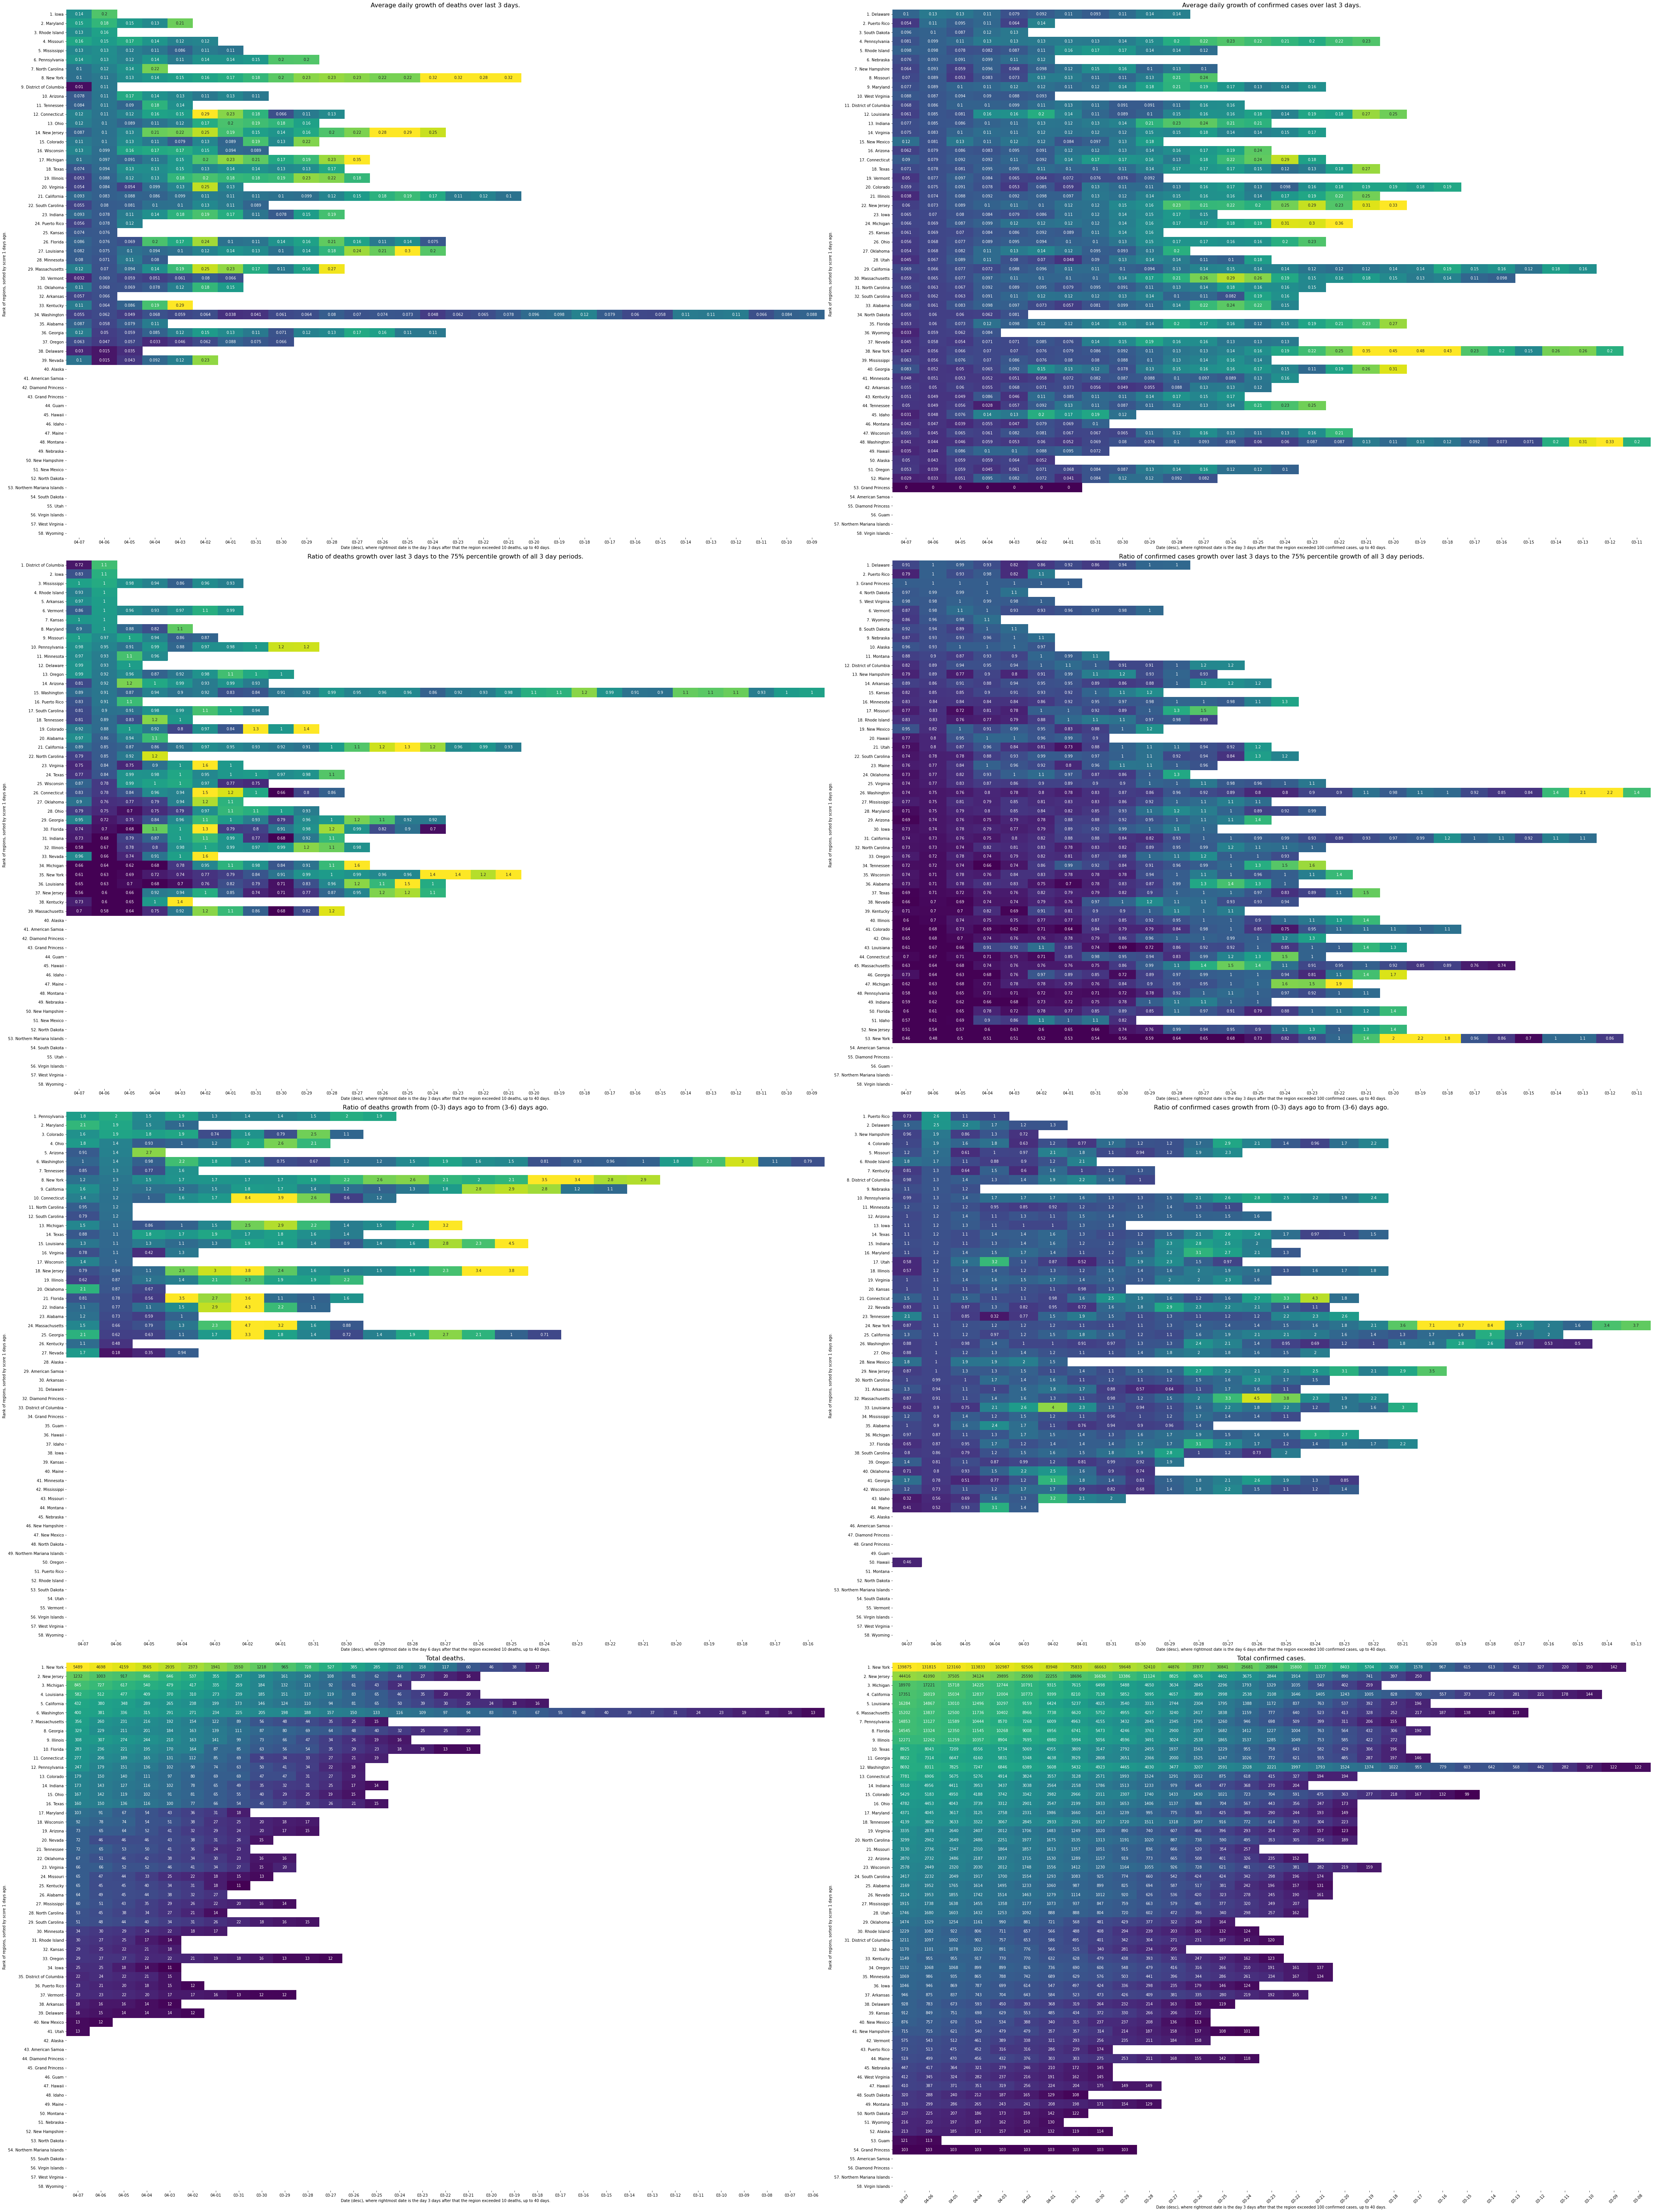

In [238]:
for domain in ['global', 'US']:
    death_threshold = 10
    confirms_threshold = 100
    compare_period=3
    if domain == 'US':
        width = 60
        length = 80
    else:
        width = 60
        length = 200
    fig, axs = plt.subplots(4, 2, figsize=(width, length))
    death_growth = gen_analysis('deaths', domain, threshold=death_threshold, compare_period=compare_period, mode='growth', ax=axs[0,0])
    death_vs_peak = gen_analysis('deaths', domain, threshold=death_threshold, compare_period=compare_period, mode='growth vs peak', ax=axs[1,0])
    death_diff = gen_analysis('deaths', domain, threshold=death_threshold, compare_period=compare_period, mode='diff', ax=axs[2,0])
    death_total = gen_analysis('deaths', domain, threshold=death_threshold, compare_period=compare_period, mode='total', ax=axs[3,0])
    confirmed_growth = gen_analysis('confirmed', domain, threshold=confirms_threshold, compare_period=compare_period, mode='growth', ax=axs[0,1])
    confirmed_vs_peak = gen_analysis('confirmed', domain, threshold=confirms_threshold, compare_period=compare_period, mode='growth vs peak', ax=axs[1,1])
    confirmed_diff = gen_analysis('confirmed', domain, threshold=confirms_threshold, compare_period=compare_period, mode='diff', ax=axs[2,1])
    confirmed_total = gen_analysis('confirmed', domain, threshold=confirms_threshold, compare_period=compare_period, mode='total', ax=axs[3,1])
    plt.tight_layout()
    plt.xticks(rotation=45)
    %time plt.savefig(f'{domain}_data_analysis.png')